In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.signal import find_peaks, periodogram
from scipy.ndimage import gaussian_filter1d
import gpytorch
import torch

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import train_gp
from dipper.model_utils.utils import check_identified_anomalies

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Grid search for each lightcurve
Iterate over every possible anomalous interval (from nyquist frequency to 10% of lightcurve) in lightcurve, and train GP on data without this interval.
Choose  most likely interval using the lowest metric.

In [2]:
data_dir = "../results/"
data_name = "grid_search_multiple_loc" 

# Load periodic lc data and flat lc data into separate dataframes
PERIODIC_LC = [3, 9, 29, 43, 48, 70]
FLAT_LC = [17, 18, 27, 28, 44]

for i in PERIODIC_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big periodic dataframe
    if i == PERIODIC_LC[0]:
        periodic = curr
    else:
        periodic = pd.concat([periodic, curr])

for i in FLAT_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big flat dataframe
    if i == FLAT_LC[0]:
        flat = curr
    else:
        flat = pd.concat([flat, curr])

# Load whitenoise: data_dir + data_name + "/whitenoise.csv"
whitenoise = pd.read_csv(data_dir + data_name + "/whitenoise.csv")

# Convert the identified column to a int; "[1.0]" = 1, "[0.0]" = 0
periodic["identified"] = periodic["identified"].apply(lambda x: int(x[1]))
flat["identified"] = flat["identified"].apply(lambda x: int(x[1]))
whitenoise["identified"] = whitenoise["identified"].apply(lambda x: int(x[1]))

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped_periodic = periodic.groupby(["snr", "period_scale", "file_number"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_periodic["identified_ratio"] = grouped_periodic["num_identified"] / grouped_periodic["total_experiments"]

grouped_flat = flat.groupby(["snr", "period_scale", "file_number"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_flat["identified_ratio"] = grouped_flat["num_identified"] / grouped_flat["total_experiments"]

grouped_whitenoise = whitenoise.groupby(["snr", "period_scale", "file_number"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_whitenoise["identified_ratio"] = grouped_whitenoise["num_identified"] / grouped_whitenoise["total_experiments"]

# Period_scale to 2 decimal places
grouped_periodic["period_scale"] = grouped_periodic["period_scale"].apply(lambda x: round(x, 3))
grouped_flat["period_scale"] = grouped_flat["period_scale"].apply(lambda x: round(x, 3))
grouped_whitenoise["period_scale"] = grouped_whitenoise["period_scale"].apply(lambda x: round(x, 3))

print(len(grouped_periodic))
print(len(grouped_flat))
print(len(grouped_whitenoise))

107
89
11


### Whitenoise plot

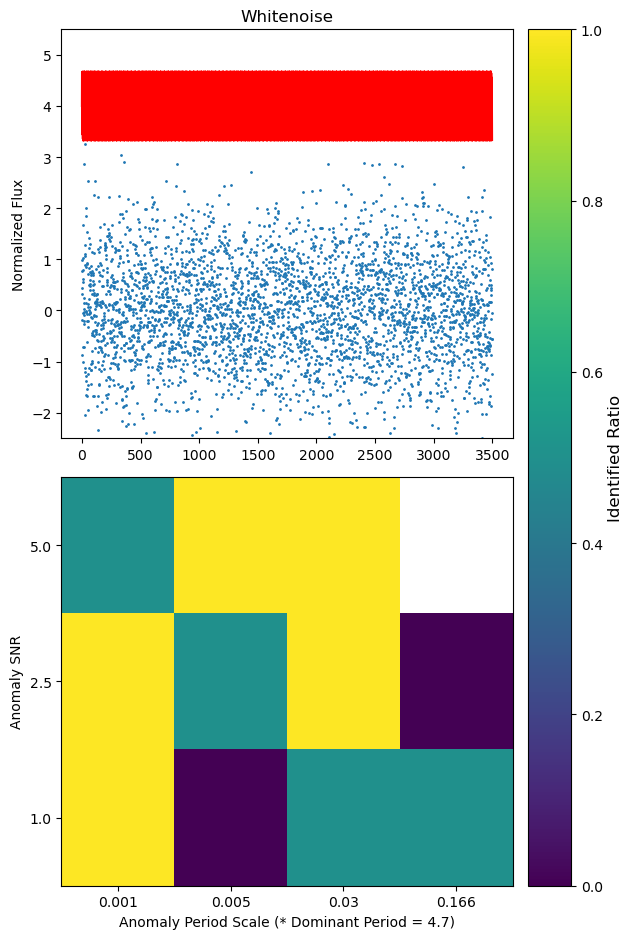

In [3]:
# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_whitenoise['identified_ratio'].min()
vmax = grouped_whitenoise['identified_ratio'].max()

# Load the associated lightcurve
k2_data_dir = '../data/'
k2_data_filename = f'whitenoise.fits'
hdu = fits.open('../data/whitenoise.fits')
x = hdu[0].data[0]
y = hdu[0].data[1]
y_err = hdu[0].data[2]

# Convert to native byte order
x = x.byteswap().newbyteorder()
y = y.byteswap().newbyteorder()
y_err = y_err.byteswap().newbyteorder()

# Create column that converts period_scale to actual value (multiply by the dominant period)
freqs, power = periodogram(y)
peaks, _ = find_peaks(power)
if len(peaks) == 0:
    print("No peaks found in power spectrum, using shoulder instead")
    smooth_power = gaussian_filter1d(power, 2)
    slope = np.gradient(smooth_power, freqs)
    shoulder_idx = np.where(slope < 0)[0][0]
    dominant_period = 1 / freqs[shoulder_idx]
    
else:
    dominant_peak = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / freqs[dominant_peak]

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot lightcurve in axs[0, i]
time_steps = np.arange(len(x))
axs[0].plot(time_steps, y, '.', markersize=2)
axs[0].set_title(f"Whitenoise")

# Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
snr = 1
noise = np.median(np.abs(y - np.median(y)))
amp = snr * noise
y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
axs[0].plot(time_steps, y_sin, color='r', label='Dominant Period with Amplitude 1 SNR')

# Show x-ticks and labels for every subplot
axs[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[0].set_ylabel("Normalized Flux")
axs[0].set_ylim([-2.5, 5.5])

# Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
pivot = grouped_whitenoise.pivot(index='snr', columns='period_scale', values='identified_ratio')
pivot = pivot.reindex(index=pivot.index[::-1])

axs[1].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_ylabel("Anomaly SNR")
axs[1].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
axs[1].set_xticks(range(len(pivot.columns)), pivot.columns)
axs[1].set_yticks(range(len(pivot.index)), pivot.index)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.1, pad=0.03)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure

plt.savefig(data_dir + data_name + "/whitenoise.png", bbox_inches='tight')
plt.show()

### Periodic plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


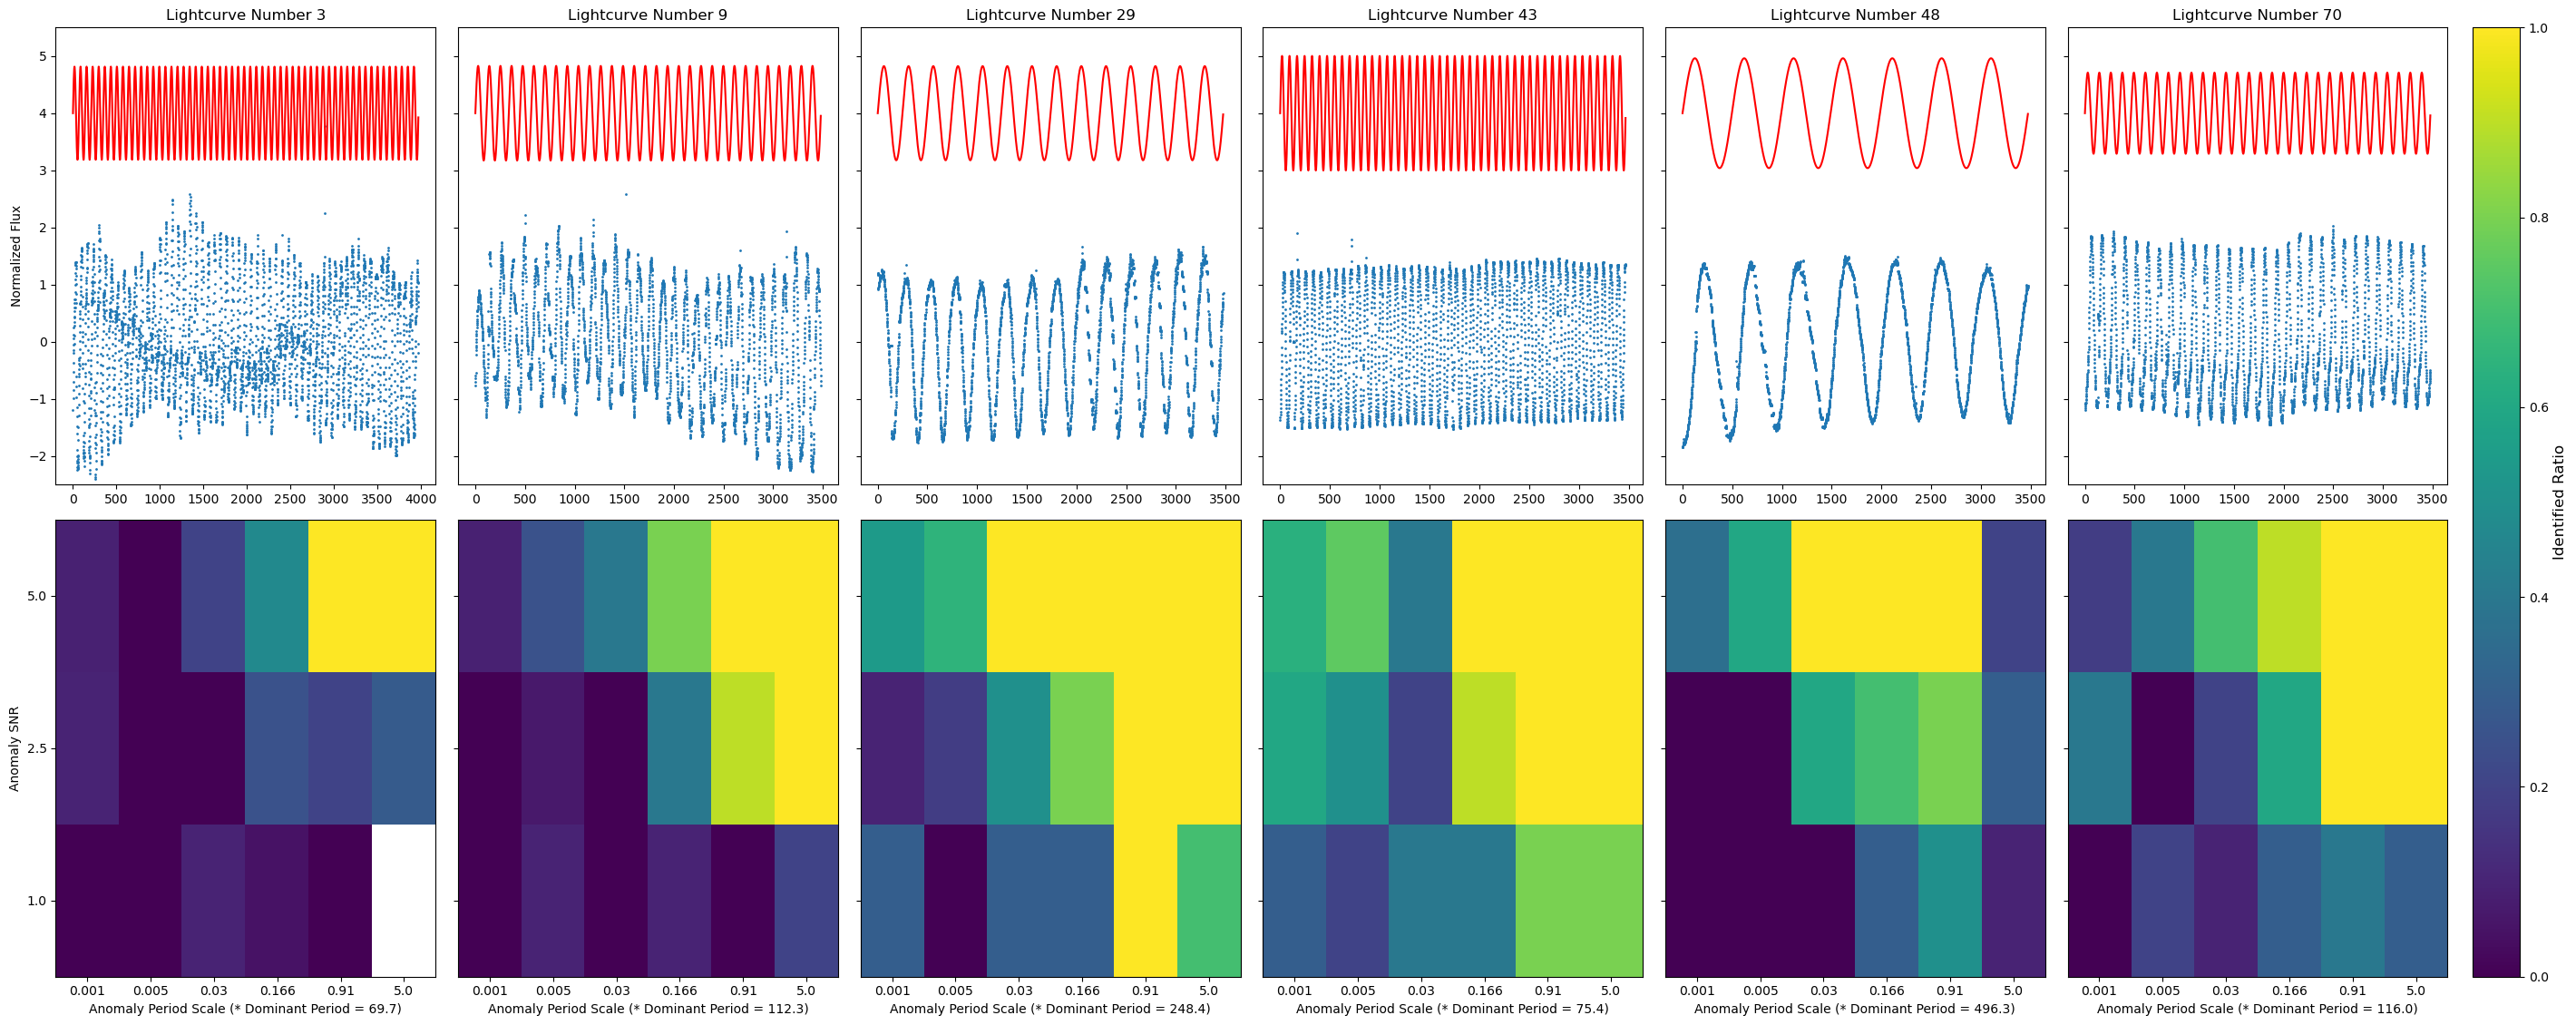

In [4]:
# Create figure
fig, axs = plt.subplots(2, 6, figsize=(28, 12))
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_periodic['identified_ratio'].min()
vmax = grouped_periodic['identified_ratio'].max()

# Plot each file and location
for i, number in enumerate(PERIODIC_LC):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_periodic[grouped_periodic['file_number'] == number]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{number}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {number}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')
    pivot = pivot.reindex(index=pivot.index[::-1])

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + "/periodic.png", bbox_inches='tight')
plt.show()

### Flat plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

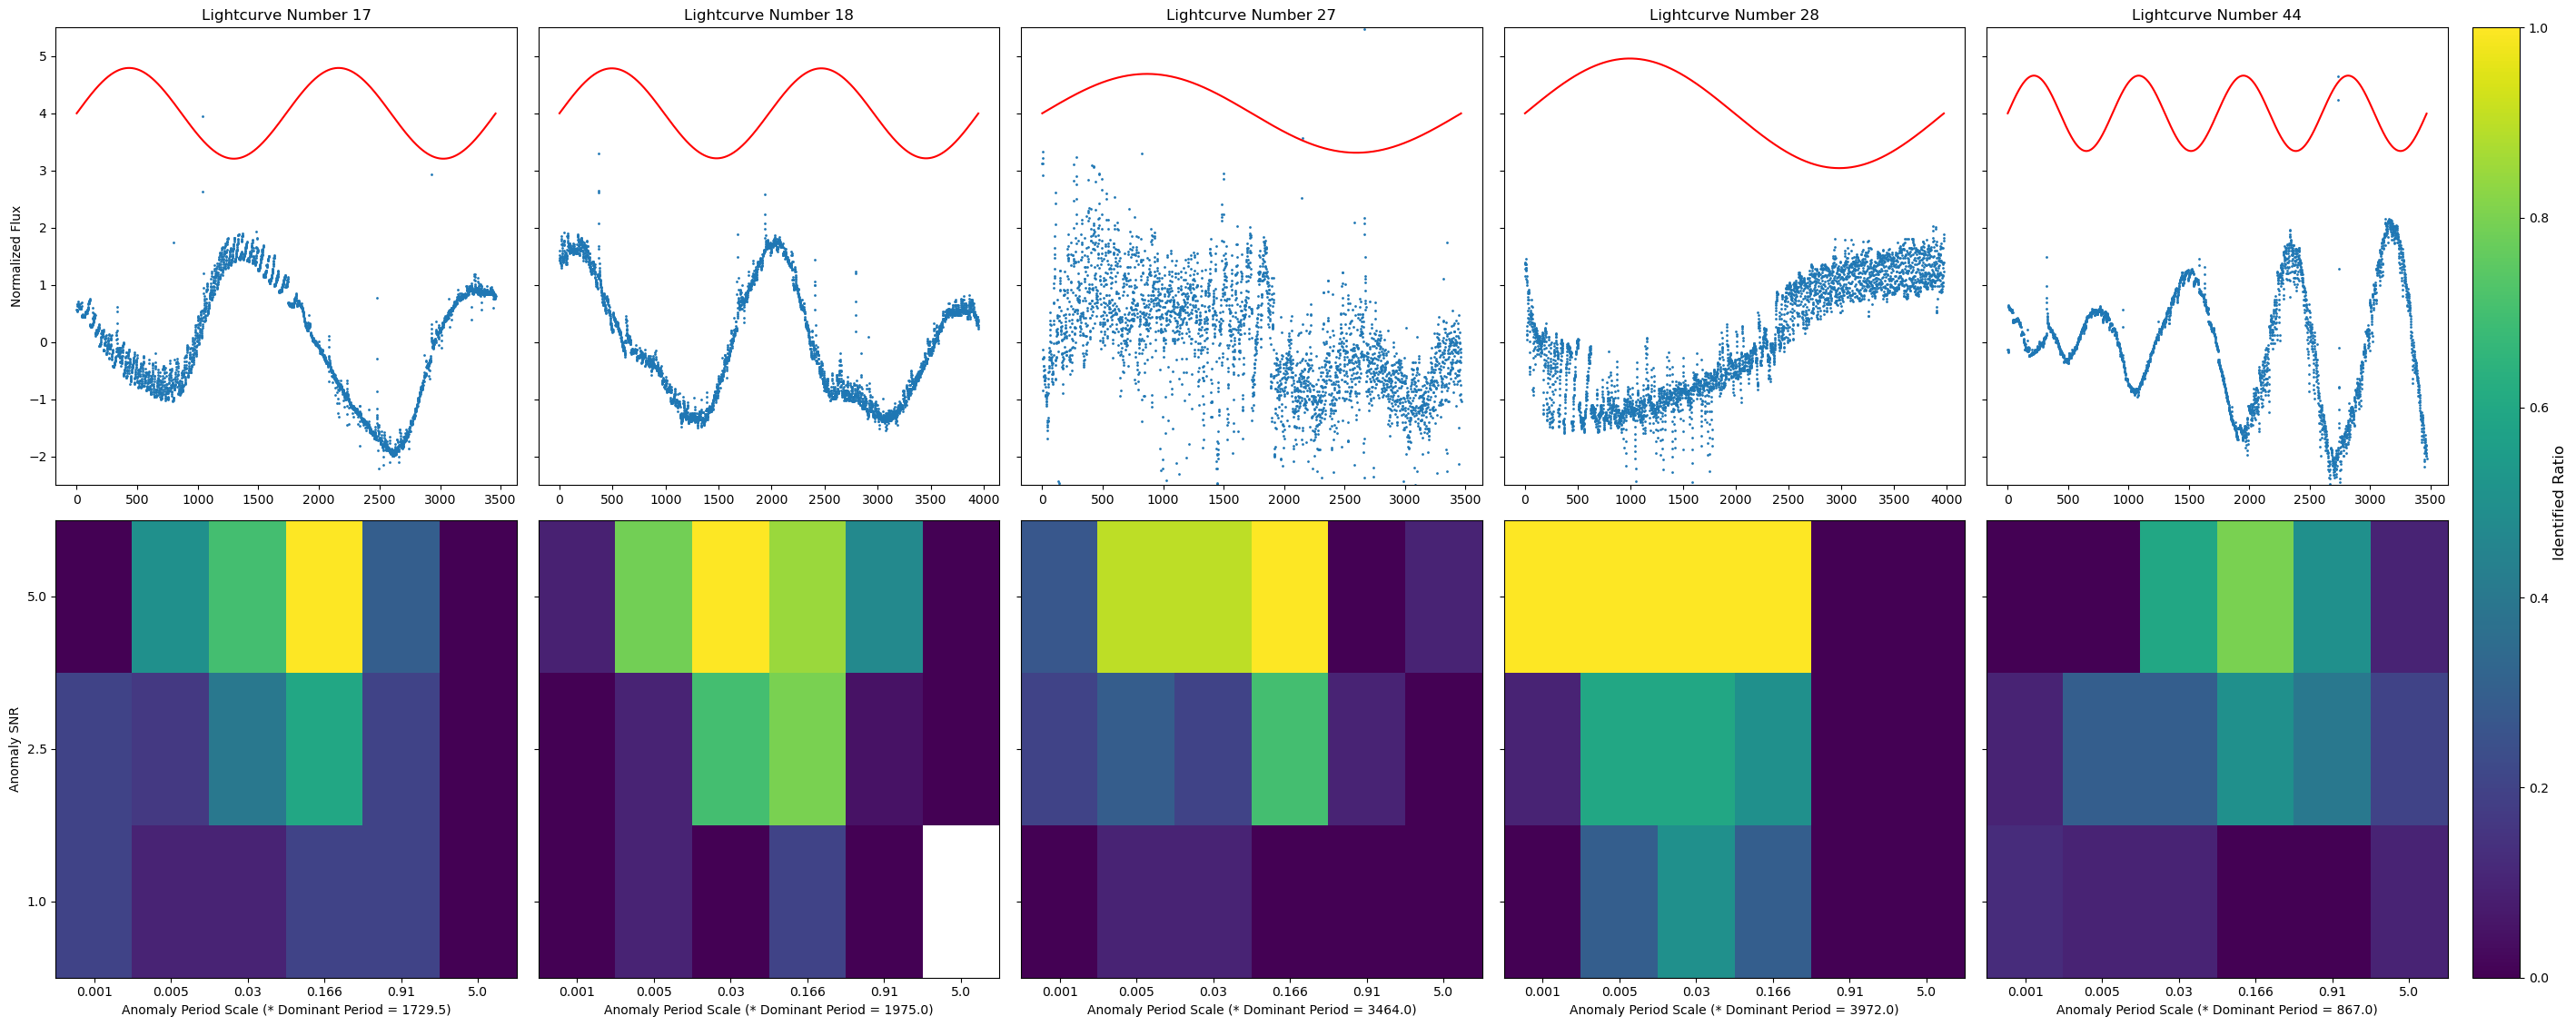

In [5]:
# Create figure
fig, axs = plt.subplots(2, 5, figsize=(28, 12))
# fig.suptitle("Ratio of Recovered Anomalies", fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_flat['identified_ratio'].min()
vmax = grouped_flat['identified_ratio'].max()

# Plot each filename and location
for i, number in enumerate(FLAT_LC):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_flat[grouped_flat['file_number'] == number]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{number}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {number}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')
    pivot = pivot.reindex(index=pivot.index[::-1])

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + "/flat.png", bbox_inches='tight')
plt.show()

## Grow deviant for each lightcurve
Create a large plot of lightcurve above with pivot imshow below each lightcurve, for the flat and periodic lightcurves separately

In [6]:
data_dir = "../results/"
data_name = "gp_periodic_vs_flat_compare_grid_2" 
len_deviant = 1

# Load periodic lc data and flat lc data into separate dataframes
PERIODIC_LC = [3, 9, 29, 43, 48, 70]
FLAT_LC = [17, 18, 27, 28, 44]

for i in PERIODIC_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big periodic dataframe
    if i == PERIODIC_LC[0]:
        periodic = curr
    else:
        periodic = pd.concat([periodic, curr])

for i in FLAT_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big flat dataframe
    if i == FLAT_LC[0]:
        flat = curr
    else:
        flat = pd.concat([flat, curr])

# Load whitenoise: data_dir + data_name + "/whitenoise.csv"
whitenoise = pd.read_csv(data_dir + data_name + "/whitenoise.csv")

# Convert the identified column to a int; "[1.0]" = 1, "[0.0]" = 0
periodic["identified"] = periodic["identified"].apply(lambda x: int(x[1]))
flat["identified"] = flat["identified"].apply(lambda x: int(x[1]))
whitenoise["identified"] = whitenoise["identified"].apply(lambda x: int(x[1]))

# Only keep the rows where column len_deviant == len_deviant
periodic = periodic[periodic["len_deviant"] == len_deviant]
flat = flat[flat["len_deviant"] == len_deviant]
whitenoise = whitenoise[whitenoise["len_deviant"] == len_deviant]

# Get unique filenames and locations
filenames_periodic = periodic['filename'].unique()
short_filenames_periodic = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames_periodic]

filenames_flat = flat['filename'].unique()
short_filenames_flat = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames_flat]

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped_periodic = periodic.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_periodic["identified_ratio"] = grouped_periodic["num_identified"] / grouped_periodic["total_experiments"]

grouped_flat = flat.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_flat["identified_ratio"] = grouped_flat["num_identified"] / grouped_flat["total_experiments"]

grouped_whitenoise = whitenoise.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_whitenoise["identified_ratio"] = grouped_whitenoise["num_identified"] / grouped_whitenoise["total_experiments"]

# Period_scale to 2 decimal places
grouped_periodic["period_scale"] = grouped_periodic["period_scale"].apply(lambda x: round(x, 3))
grouped_flat["period_scale"] = grouped_flat["period_scale"].apply(lambda x: round(x, 3))
grouped_whitenoise["period_scale"] = grouped_whitenoise["period_scale"].apply(lambda x: round(x, 3))

print(len(grouped_periodic))
print(len(grouped_flat))
print(len(grouped_whitenoise))

182
160
32


### Whitenoise plot

3500 3500 3500


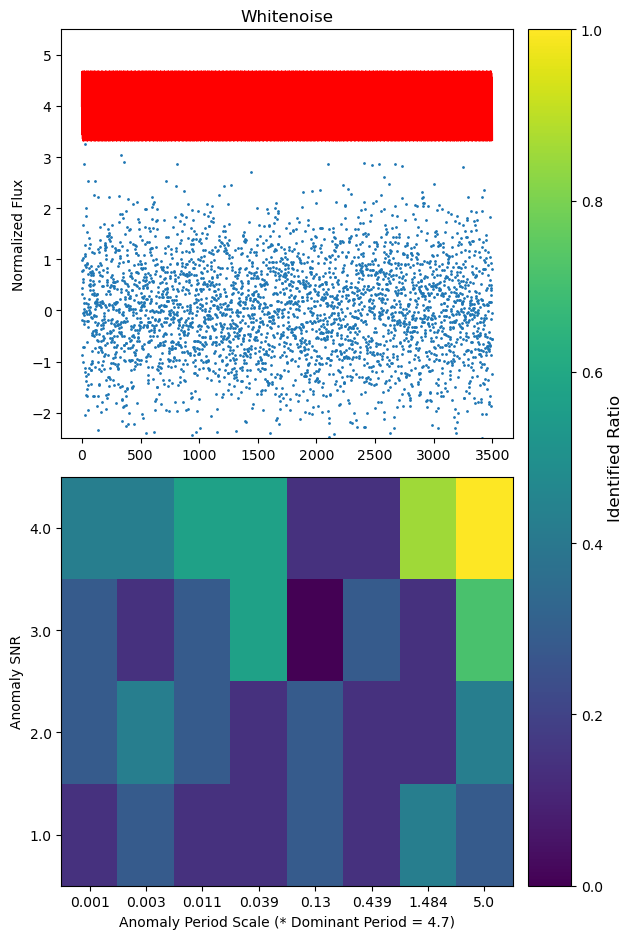

In [7]:
# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_whitenoise['identified_ratio'].min()
vmax = grouped_whitenoise['identified_ratio'].max()

# Load the associated lightcurve
k2_data_dir = '../data/'
k2_data_filename = f'whitenoise.fits'
hdu = fits.open('../data/whitenoise.fits')
x = hdu[0].data[0]
y = hdu[0].data[1]
y_err = hdu[0].data[2]

# Convert to native byte order
x = x.byteswap().newbyteorder()
y = y.byteswap().newbyteorder()
y_err = y_err.byteswap().newbyteorder()

print(len(x), len(y), len(y_err))

# Create column that converts period_scale to actual value (multiply by the dominant period)
freqs, power = periodogram(y)
peaks, _ = find_peaks(power)
if len(peaks) == 0:
    print("No peaks found in power spectrum, using shoulder instead")
    smooth_power = gaussian_filter1d(power, 2)
    slope = np.gradient(smooth_power, freqs)
    shoulder_idx = np.where(slope < 0)[0][0]
    dominant_period = 1 / freqs[shoulder_idx]
    
else:
    dominant_peak = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / freqs[dominant_peak]

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot lightcurve in axs[0, i]
time_steps = np.arange(len(x))
axs[0].plot(time_steps, y, '.', markersize=2)
axs[0].set_title(f"Whitenoise")

# Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
snr = 1
noise = np.median(np.abs(y - np.median(y)))
amp = snr * noise
y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
axs[0].plot(time_steps, y_sin, color='r', label='Dominant Period with Amplitude 1 SNR')

# Show x-ticks and labels for every subplot
axs[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[0].set_ylabel("Normalized Flux")
axs[0].set_ylim([-2.5, 5.5])

# Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
pivot = grouped_whitenoise.pivot(index='snr', columns='period_scale', values='identified_ratio')
pivot = pivot.reindex(index=pivot.index[::-1])

axs[1].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_ylabel("Anomaly SNR")
axs[1].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
axs[1].set_xticks(range(len(pivot.columns)), pivot.columns)
axs[1].set_yticks(range(len(pivot.index)), pivot.index)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.1, pad=0.03)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure

plt.savefig(data_dir + data_name + f"/whitenoise_len_deviant_{len_deviant}.png", bbox_inches='tight')
plt.show()

### Periodic plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

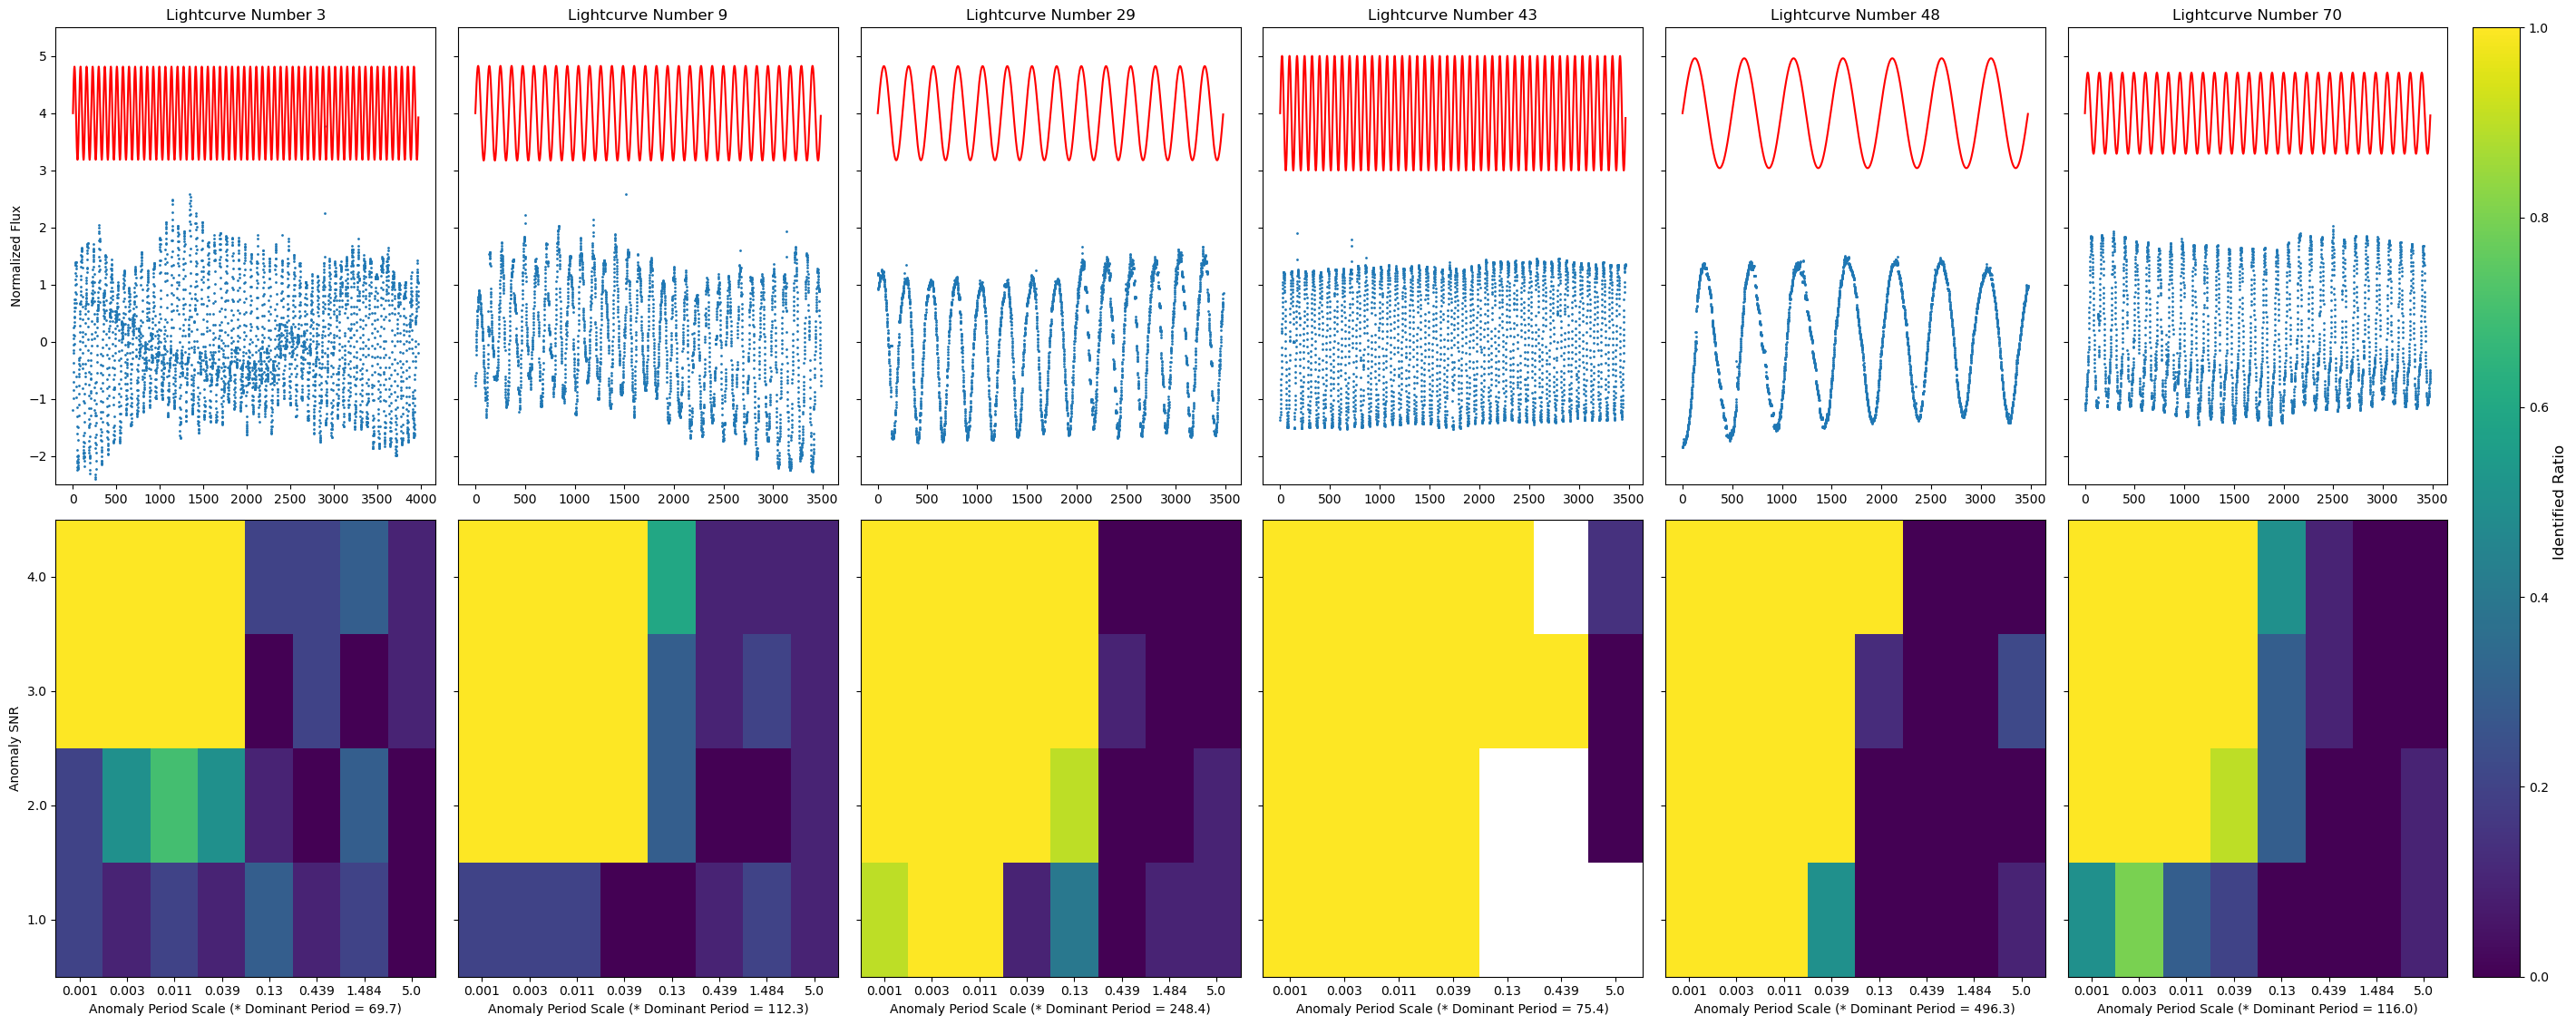

In [8]:
# Create figure
fig, axs = plt.subplots(2, 6, figsize=(28, 12))
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_periodic['identified_ratio'].min()
vmax = grouped_periodic['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames_periodic):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_periodic[grouped_periodic['filename'] == filename]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{short_filenames_periodic[i]}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {short_filenames_periodic[i]}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')
    pivot = pivot.reindex(index=pivot.index[::-1])

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + f"/periodic_len_deviant_{len_deviant}.png", bbox_inches='tight')
plt.show()

### Flat plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

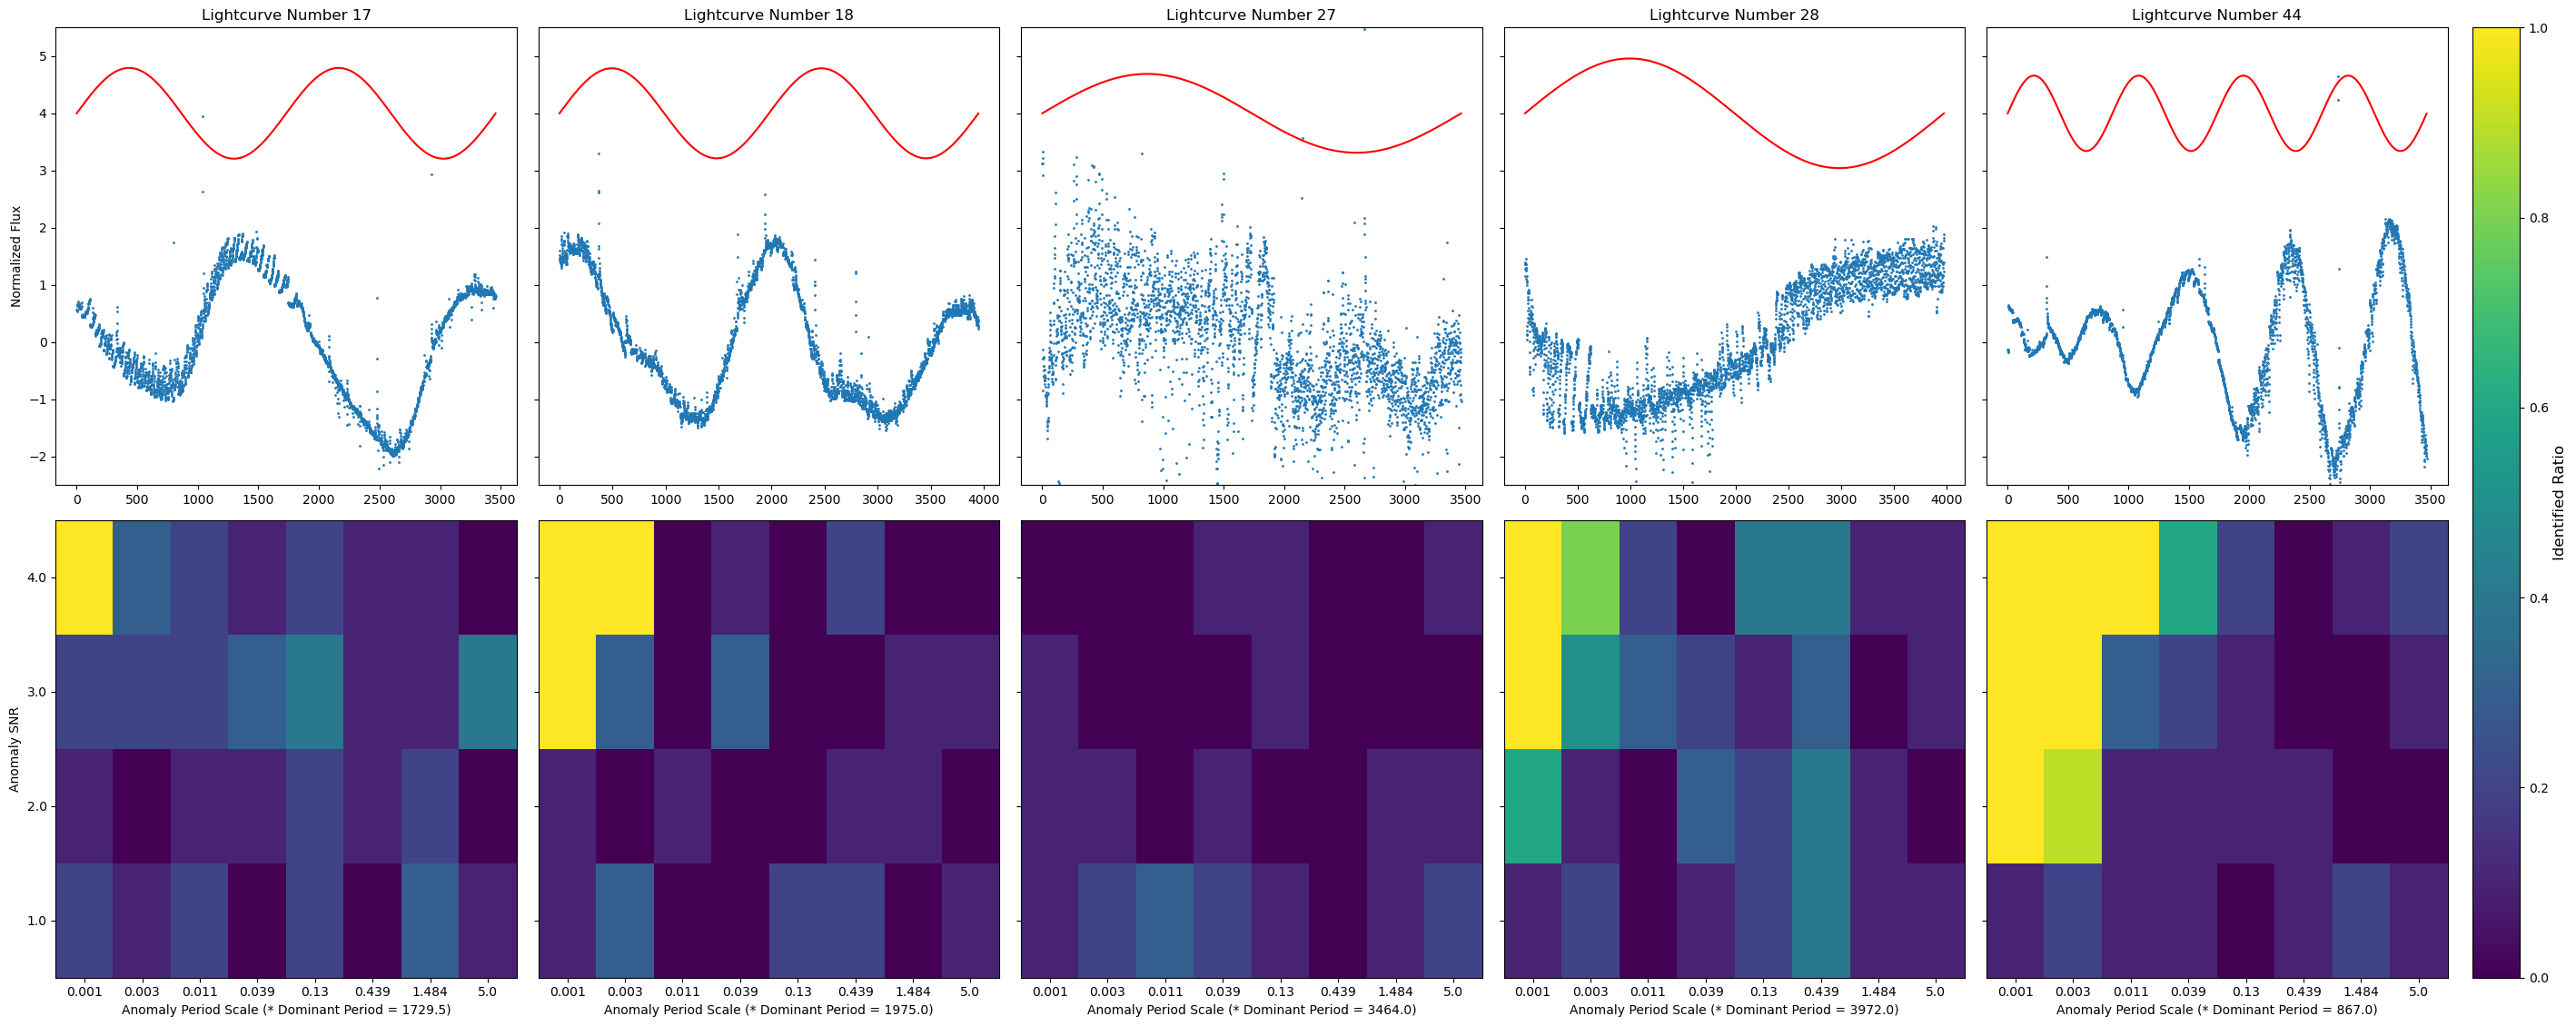

In [9]:
# Create figure
fig, axs = plt.subplots(2, 5, figsize=(28, 12))
# fig.suptitle("Ratio of Recovered Anomalies", fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_flat['identified_ratio'].min()
vmax = grouped_flat['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames_flat):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_flat[grouped_flat['filename'] == filename]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{short_filenames_flat[i]}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {short_filenames_flat[i]}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')
    pivot = pivot.reindex(index=pivot.index[::-1])

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + f"/flat_len_deviant_{len_deviant}.png", bbox_inches='tight')
plt.show()